# Non-parametric system identification on the time domain

Goal: Estimate the impulse response of a simulated linear time-invariant (LTI) system using nonparametric methods.

Have to assume first, second, ... order 


# Causal LTI systems:
<p>
Output of the system can be described as a convulution of the input and its impulse response + noise
$$
y[n] =g_o[n] * u[n] + v[n]
$$

$y$ represents output, $g$ represents impulse response, $u$ represents input, $v$ represents noise.

$$
y[n] = ∑_{k=0}^{∞}g_o[k]u[n-k]+v[n]
$$
</p>

<p>
Choose input in a clever way, option 1 (Dirac delta):
$$
u[n] =
\begin{cases}
\alpha & \text{if } n = 0 \\
0 & \text{else}
\end{cases}
\\
y[n] = αg_o[n]+v[n]
\\
\hat{g}[n] = \frac{y[n]}{\alpha}
$$
</p>

<p>
Choose input in a clever way, option 2 (unit step):
$$u[n] =
\begin{cases}
\alpha & \text{if } n \geq 0 \\
0 & \text{else}
\end{cases}
\\
y[n] - y[n-1] = ∑_{k=n}^{∞}\alpha g_o[k]+v[n] - ∑_{k=n+1}^{∞}\alpha g_o[k]-v[n-1] = \alpha g_o[n] + v[n] - v[n-1]
\\
\hat{g}[n] = \frac{y[n]-y[n-1]}{\alpha}
$$
</p>

<p>
Notes:


*   If the estimate for $\hat{g}[n]$ is very different depending on choice of $u[n]$, the system may not be linear enough
*   Larger $\alpha$ reduces impact of noise $v[n]$ on the estimate, but may be impractical
</p>


In [1]:
def rk4(f,h,x,*args):
    k1 = f(x,*args)
    k2 = f(x+k1*h/2, *args)
    k3 = f(x+k2*h/2, *args)
    k4 = f(x+k3*h, *args)
    return x + h*(k1+2*k2+2*k3+k4)/6

# First Order linear system

$$
 y = c*x\\
\dot{x} = -ax + bu, a >0\\
 for,c = 1\\
 \dot{x} = \dot{y}
$$

In [2]:
import numpy as np
def fist_order(x,u):
  a = 2
  b = 8
  return -a*x+b*u

In [3]:
#hide

def sim(f, x0, u ,time=10, dt = 0.1):

  N = int(time/dt)
  x = [x0]
  if callable(u):
    u = u(np.arange(0,N*dt, dt))
  for i in range(len(u)):
    x.append(rk4(f,dt,x[-1],u[i]))
  x = np.array(x)
  return x[1:],u, np.arange(0,N*dt, dt)


In [4]:
import numpy as np

Diraic_delta_alpha = 2

def dirac_delta(t,t0=2):
  return np.where(t == t0, Diraic_delta_alpha, 0)

def unit_step(t,t0=2):
  return np.where(t >= t0, Diraic_delta_alpha, 0)

def sine(t,t0=2):
  freq = 0.5
  return np.sin(2*np.pi*freq*t+t0)

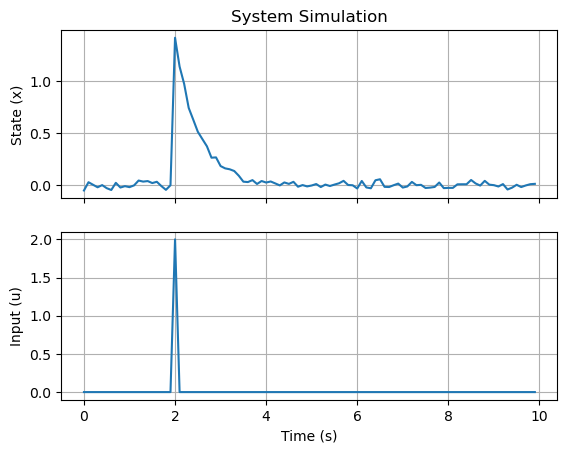

In [5]:
#Simulate an impuse as response to direct delta (very very short input).
x1,u1, t = sim(fist_order,0, dirac_delta)
mean = 0
std_deviation = 0.025

x1 =x1 + np.random.normal(mean, std_deviation,x1.shape )
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, x1)
ax1.set_ylabel("State (x)")
ax1.set_title("System Simulation")
ax1.grid()

ax2.plot(t, u1)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Input (u)")
ax2.grid()

plt.show()

### From this we can estimate som stuff.
$$
y[n] = αg_o[n]+v[n]
\\
\hat{g}[n] = \frac{y[n]}{\alpha}
$$

$
u[n] =
\begin{cases}
\alpha & \text{if } n = 0 \\
0 & \text{else}
\end{cases}
$

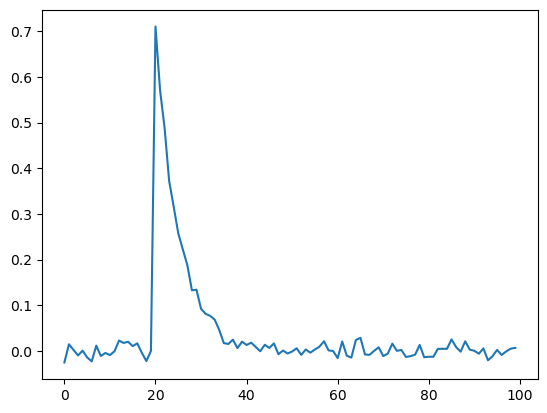

In [6]:
# Estimate impulse response
g_hat = x1/Diraic_delta_alpha
plt.plot(g_hat)
plt.show()

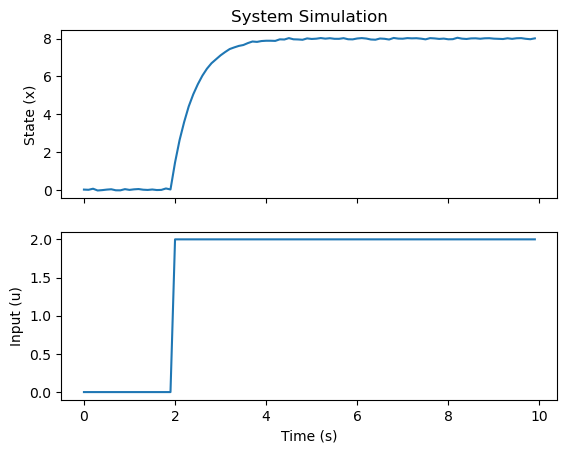

In [7]:
#simulate output for a unit step.
x2,u2, t = sim(fist_order,0, unit_step)
import matplotlib.pyplot as plt
mean = 0
std_deviation = 0.025

x2 =x2 + np.random.normal(mean, std_deviation,x2.shape )
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(t, x2)
ax1.set_ylabel("State (x)")
ax1.set_title("System Simulation")

ax2.plot(t, u2)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Input (u)")

plt.show()

### We can estimate the response
$$
y[n] = ∑_{k=0}^{∞}g_o[k]u[n-k]+v[n]
\\
u[n] =
\begin{cases}
\alpha & \text{if } n \geq 0 \\
0 & \text{else}
\end{cases}
\\
y[n] - y[n-1] = ∑_{k=n}^{∞}\alpha g_o[k]+v[n] - ∑_{k=n+1}^{∞}\alpha g_o[k]-v[n-1] = \alpha g_o[n] + v[n] - v[n-1]
\\
\hat{g}[n] = \frac{y[n]-y[n-1]}{\alpha}
$$


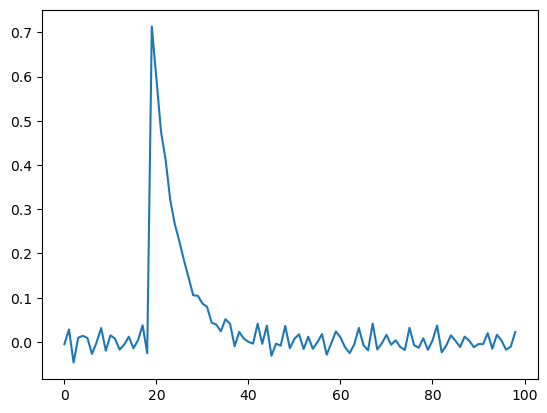

In [8]:
g_hat_2 = (x2[1:]-x2[:-1])/Diraic_delta_alpha

plt.plot(g_hat_2)
plt.show()

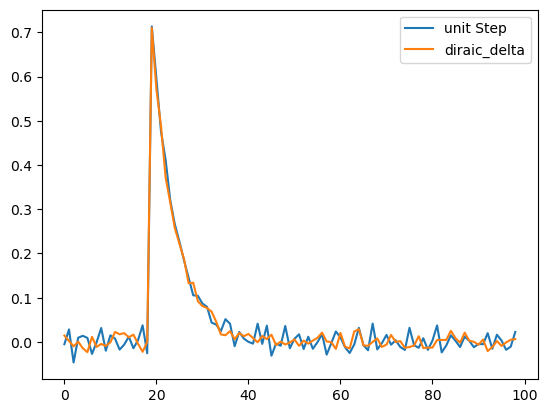

In [9]:
# We compare
g_hat_d =g_hat[1:]
g_hat_u =g_hat_2
plt.plot(g_hat_u,label = "unit Step")
plt.plot(g_hat_d, label = "diraic_delta")

plt.legend()
plt.show()

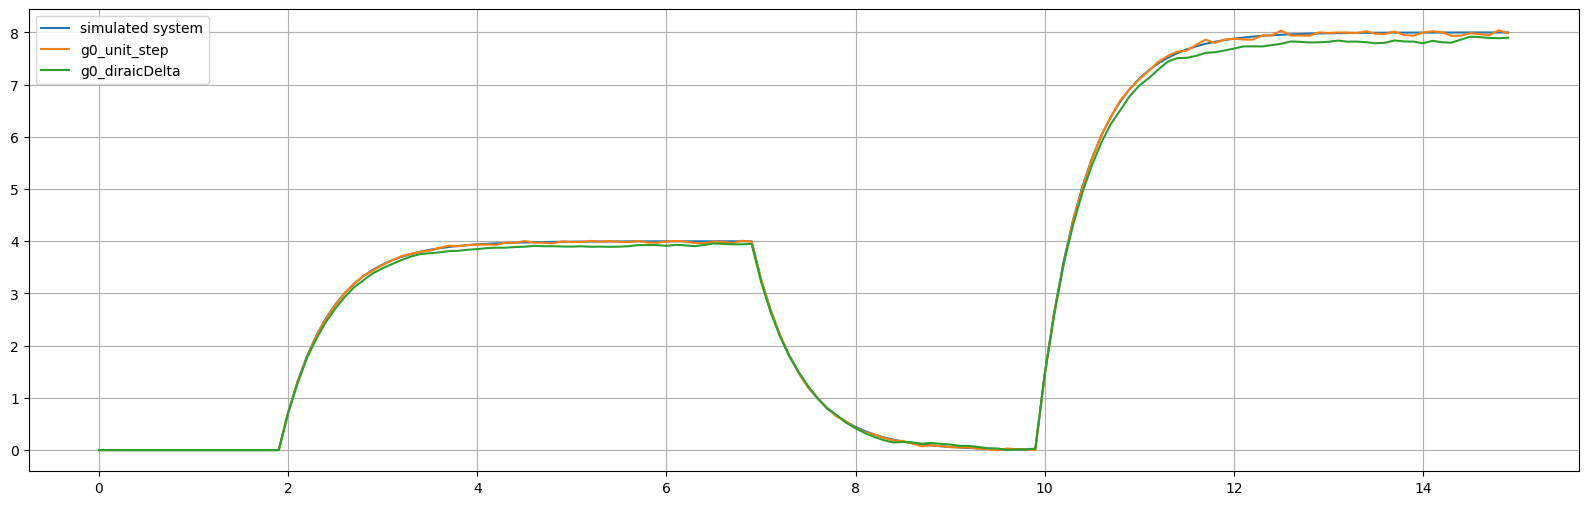

In [10]:
#Using out estimated impuse respons to model the system and comparing it with actual system


# Define the time vector with a resolution of 0.1
t = np.arange(0, 15, 0.1)

# Define the input u(t) based on the given conditions
u_t = np.piecewise(t,
                   [t < 2, (2 <= t) & (t < 7), (7 <= t) & (t < 10), (10 <= t) & (t < 15)],
                   [0, 1, 0, 2])

yu = np.convolve(u_t, g_hat_u[19:])[:len(u_t)]
yd = np.convolve(u_t, g_hat_d[19:])[:len(u_t)]

y2, _, _ = sim(fist_order,0, u_t)

plt.figure(figsize=(20, 6))
plt.plot(t[:len(y2)],y2, label = "simulated system")
plt.plot(t,yu, label = "g0_unit_step")
plt.plot(t,yd, label = "g0_diraicDelta")
plt.grid()
plt.legend()
plt.show()


## Mass damper second order!


System:
$m\ddot{x} + cẋ + kx = F$

Also known as

$$
\begin{bmatrix}
\dot{x}_1 \\ \dot{x}_2
\end{bmatrix}=
\begin{bmatrix}
  -c/m & -k/m \\
  1 & 0
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2
\end{bmatrix}+
\begin{bmatrix}
1/m \\ 0
\end{bmatrix}*F\\
y = \textbf{cx} = [0,1]\begin{bmatrix}
x_1 \\ x_2
\end{bmatrix}=x_2
$$


x_1 is speed
x_2 is position
F =

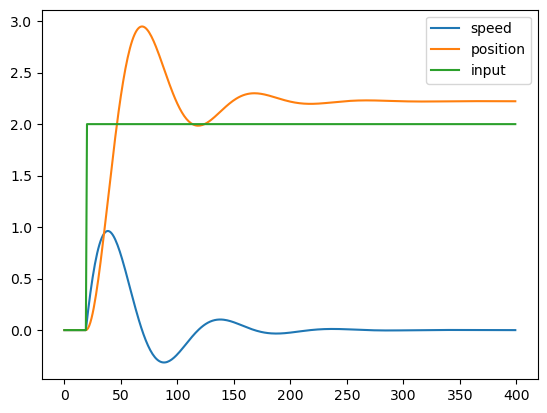

In [11]:
c = 0.9
m = 2
k = 0.9

def second_order(x,u):
  return np.array([-c/m*x[0]-k/m*x[1]+1/m*u, x[0]])

x, u,t = sim(second_order,np.array([0,0]), unit_step, time = 40)

plt.plot(x[:,0], label = 'speed')
plt.plot(x[:,1], label = 'position')
plt.plot(u, label = 'input')
plt.legend()
plt.show()

(400,)


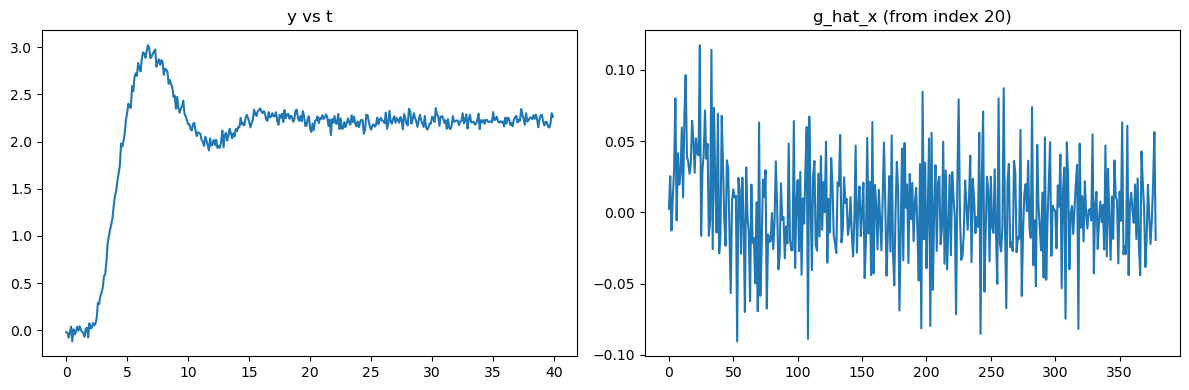

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual x, t, etc.)
# x = np.random.rand(100, 2)
# t = np.arange(100)
# mean = 0
# Diraic_delta_alpha = 0.1

print(x[:, 1].shape)

# Add noise
y = x[:, 1] + np.random.normal(mean, 0.05, x[:, 1].shape)

# Compute derivative
g_hat_x = (y[1:] - y[:-1]) / Diraic_delta_alpha

# Create a figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 12x4 inches, adjust as needed

# Left plot: y vs t
axes[0].plot(t, y)
axes[0].set_title('y vs t')

# Right plot: g_hat_x
axes[1].plot(g_hat_x[20:])
axes[1].set_title('g_hat_x (from index 20)')

plt.tight_layout()  # adjust spacing so titles/labels don't overlap
plt.show()


### We compare to the system

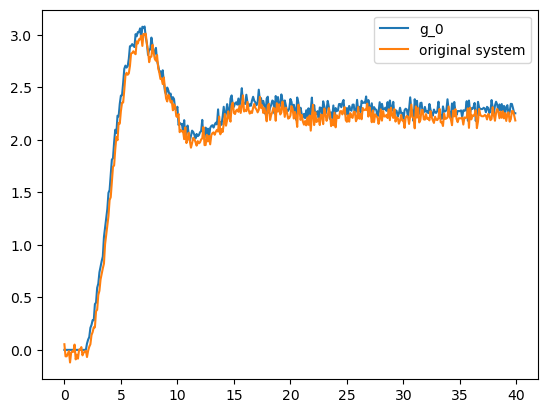

In [13]:
out = np.convolve(u, g_hat_x[20:])

plt.plot(t[:len(out)],out[:len(t)], label = "g_0")
plt.plot(t[:len(y)],y, label = "original system")
plt.legend()
plt.show()

# A practical example - Metal refining



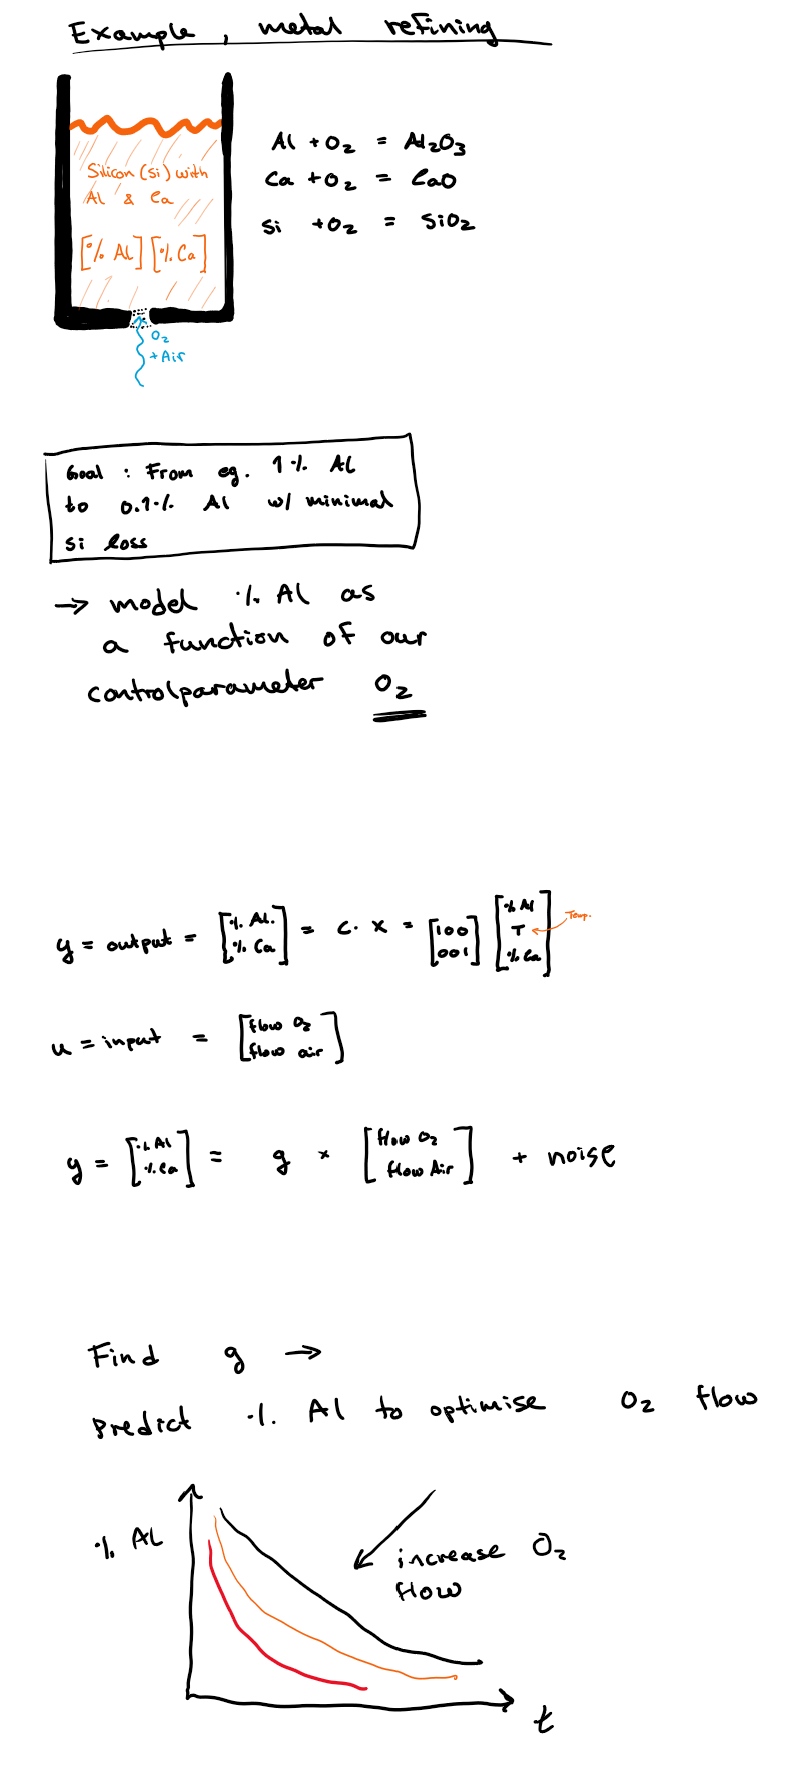